# Tree appoach

## Import library
 

- *pandas* for managing data frame efficiently
- *matplotlib* for visualizing data
- *seaborn* provides various fascinating themes for visualization
- *numpy* for working with array
- *sklearn* provides some evaluate metrics, fast-used machine learning algorithms, choosing good hyperparameters
- *h2o* provides "Extended Isolation Forest" algorithm
-> For more details, go to "https://docs.h2o.ai/h2o/latest-stable/h2o-docs/data-science/eif.html"
-> For better understanding algorithm, go to "https://arxiv.org/abs/1811.02141"

In [2]:
# Disable warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     |████████████████████████████████| 177.0 MB 45 kB/s 
  Created wheel for h2o: filename=h2o-3.36.1.2-py2.py3-none-any.whl size=177070945 sha256=d44d98fd18a065cf885ee4f2fea69a80833b77639f3e1f280a7ebcb0301d08cb
  Stored in directory: /root/.cache/pip/wheels/a5/2b/ae/534595df09001e1573b1046be62a3f049507307340119db65c
Successfully built h2o


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split, ShuffleSplit

In [5]:
import h2o
from h2o.estimators import H2OExtendedIsolationForestEstimator
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.15" 2022-04-19; OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1); OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.7/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpm626ismd
  JVM stdout: /tmp/tmpm626ismd/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpm626ismd/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.2
H2O_cluster_version_age:,1 month and 1 day
H2O_cluster_name:,H2O_from_python_unknownUser_7lg27u
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.172 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


## Importing data

In [7]:
df = pd.read_csv('./dataset/life_expectancy_prep.csv')

X_train = pd.read_csv('../dataset/X_train.csv').drop(columns=['country'])
y_train = pd.read_csv('../dataset/y_train.csv')

X_test = pd.read_csv('../dataset/X_test.csv').drop(columns=['country'])
y_test = pd.read_csv('../dataset/y_test.csv')

## Exploratory analysis


### Removing linear correlated features


In [8]:
#Observing the statistical information of numerical columns in the data 
X_train.describe()

,year,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under_five_deaths,polio,...,thinness_5_9_years,income_composition_of_resources,schooling,status_Developed,status_Developing,continent_Africa,continent_Americas,continent_Asia,continent_Europe,continent_Oceania
count,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,...,2.196000e+03,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000,2196.000000
mean,2007.513661,164.525046,30.948543,5.256289,744.264228,559.627436,2327.743625,49.271539,42.727687,82.444048,...,3.790522e+04,0.816156,11.576913,0.175319,0.824681,0.294627,0.184882,0.253643,0.212659,0.054189
std,4.595461,123.226638,121.125818,12.976834,2002.114759,3323.824924,10786.349426,177.623183,163.711000,23.548978,...,5.897960e+05,1.116700,3.808738,0.380326,0.380326,0.455979,0.388290,0.435195,0.409282,0.226443
min,2000.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.400000,0.000000,3.000000,...,1.000000e-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2004.000000,74.000000,0.000000,0.787500,5.371728,76.000000,0.000000,19.200000,0.000000,77.000000,...,1.500000e+00,0.500000,9.600000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2008.000000,144.000000,3.000000,3.675000,67.337581,93.000000,17.000000,43.600000,4.000000,93.000000,...,3.400000e+00,0.683000,12.100000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2012.000000,227.000000,22.000000,7.820000,454.422430,98.000000,341.000000,56.300000,29.000000,97.000000,...,7.325000e+00,0.791000,14.100000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,2015.000000,723.000000,1800.000000,455.000000,19479.911610,91242.500000,182485.000000,4832.000000,2500.000000,99.000000,...,1.228331e+07,12.300000,20.700000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


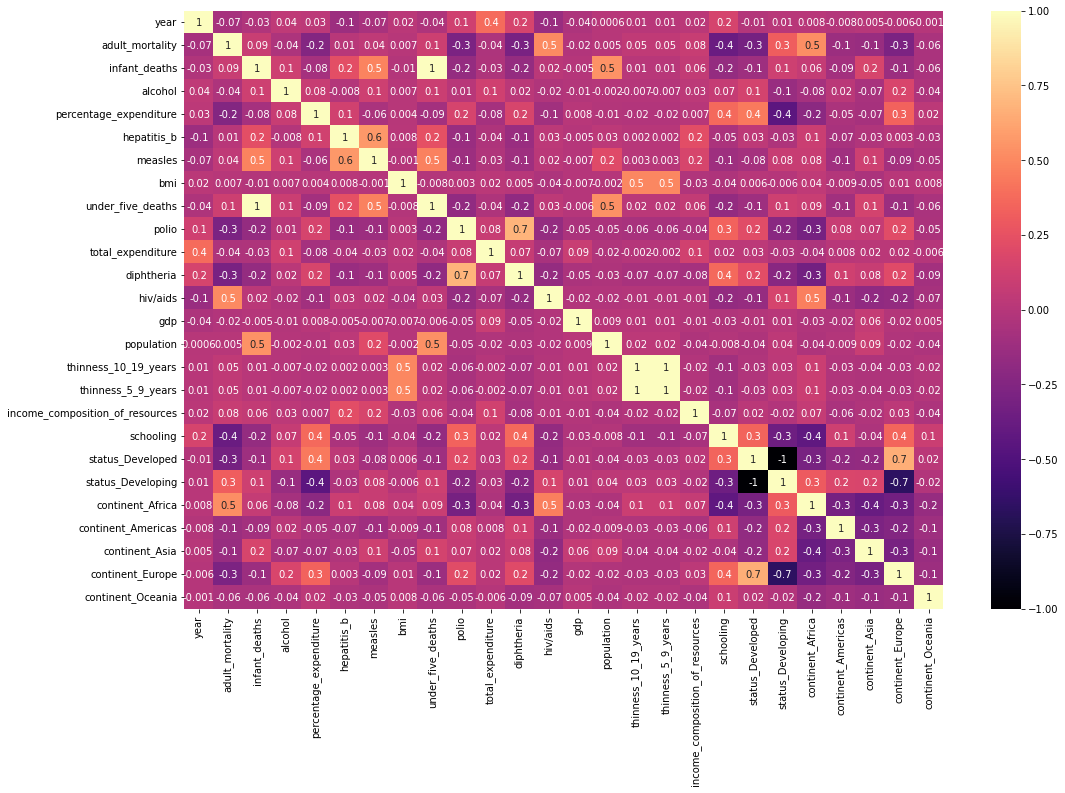

In [9]:
#Observing the correlation between each feature in the data
plt.figure(figsize=(17,11))
sns.heatmap(X_train.corr(), annot=True, cmap="magma", fmt='.1g')

- "under_five_deaths" and "infant_deaths" have correlation of 1.0
- "thinness_5_9_years" and "thinness_10_19_years" have correlation of 0.9
- "schooling" and "income_composition_of_resources" have correlation of 0.8
- "gdp" and "percentage_expenditure" have correlation of 0.9

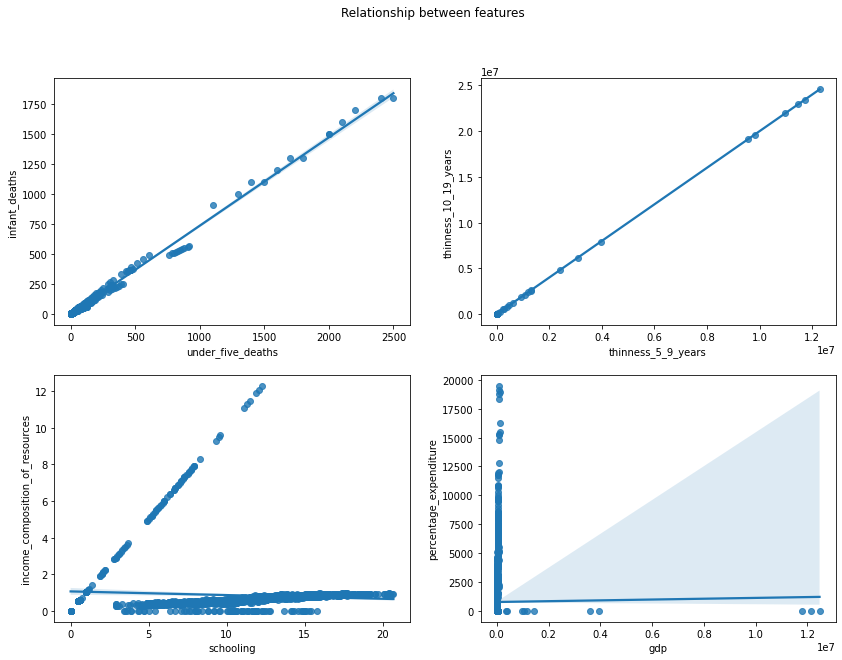

In [10]:
#Plot graph to see relationship between these features
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Relationship between features')

sns.regplot(ax=axes[0,0], x=X_train['under_five_deaths'], y=X_train['infant_deaths'])

sns.regplot(ax=axes[0,1], x=X_train['thinness_5_9_years'], y=X_train['thinness_10_19_years'])

sns.regplot(ax=axes[1,0], x=X_train['schooling'], y=X_train['income_composition_of_resources'])

sns.regplot(ax=axes[1,1], x=X_train['gdp'], y=X_train['percentage_expenditure'])


- "infant_deaths" and "under_five_deaths" almost have linear relationship with each other, thus can remove 1 in 2, we choose "under_five_deaths".
- "thinness_5_9_years" and "thinness_10_19_years" almost have linear relationship with each other, thus can remove 1 in 2, we choose "thinness_10_19_years".
- "schooling" and "income_composition_of_resources" might be linearly correlated, but some data points don't follow that, so we haven't concluded yet.
- Linear line between "gdp" and "percentage_expenditure" seems fluctuate around an angle, we haven't concluded yet.  

In [11]:
columns_drop = ["under_five_deaths", "thinness_10_19_years"]

### Relationship between explanatory vars and response var

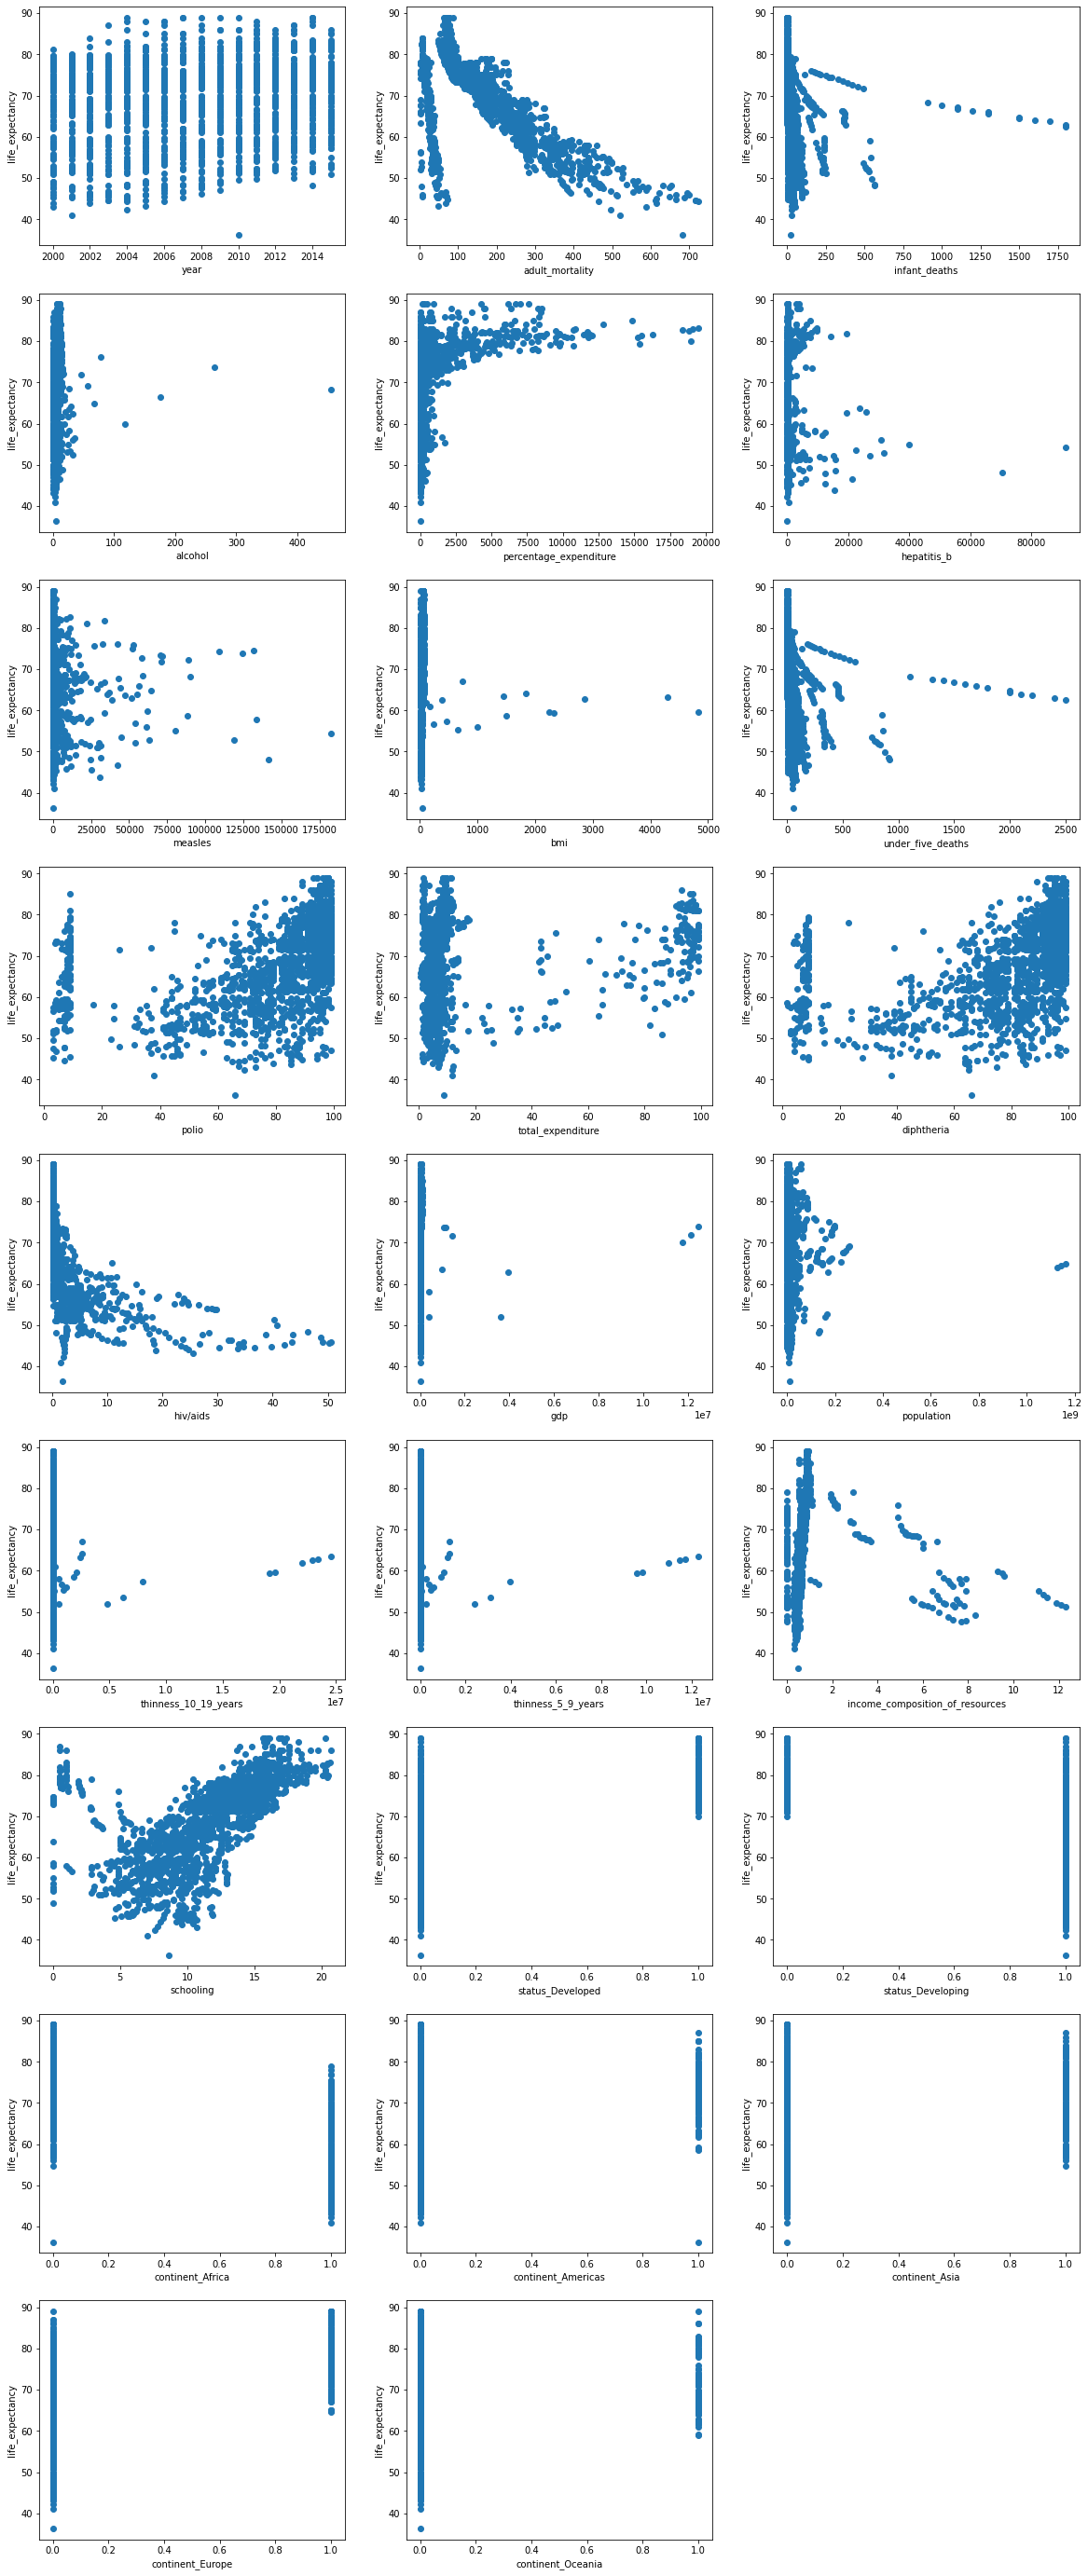

In [12]:
fig.suptitle('Relationship between attributes and label')
plt.figure(figsize=(20,50))
for idx, col in enumerate(X_train.columns):
    plt.subplot(X_train.shape[1]//3+1, 3, idx+1)
    plt.plot(X_train[col], y_train, 'o')
    plt.xlabel(col)
    plt.ylabel(y_train.columns[0])

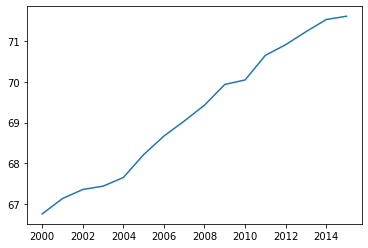

In [13]:
plt.plot(df.groupby(['year']).life_expectancy.mean())

- "gdp" doesn't show linear relationship with "life_expectancy", hence can remove.
- "percentage_expenditure" doesn't show linear relationship with "life_expectancy", hence can remove.

In [14]:
#dropping 'under_five_deaths', 'thinness_5_9_years' columns
columns_drop += ['percentage_expenditure', 'gdp']

### Some helpful functions

- Functions to support feature selection
1.  feature_importance: visualize data frame for importances of every feature considered.
2.  pprint: calculate three model scores including r2 score (r2), root mean square error (rmse), mean absolute error (mae), show feature importances.
3.  compare_loss: Compare model scores, feature importances before and after dropping features.

In [15]:
#testing the loss in accuracy before and after removing features 

#making dataframe for feature importances
def feature_importance(model, x_train):
  importance = model.feature_importances_ 
  feature_importance = pd.DataFrame(importance, index=x_train.columns, columns=['Importances'])
  return feature_importance.sort_values(by=['Importances'], ascending=False)

def score(y_test, y_pred, score_show=False, feature_importance_df=None, importance_show=False, return_score=False):
  r2 = r2_score(y_test, y_pred)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  mae = mean_absolute_error(y_test, y_pred)
  if score_show:
    print(f'r2 score: {r2}')
    print(f'rmse: {rmse}')
    print(f'mae: {mae}')
    if importance_show:
      print('Importances of features:')
      print(feature_importance_df)
  if return_score:    
    return r2, rmse, mae

#comparing different scores
def compare_loss(X_train, y_train, X_test, y_test, columns=[], estimator='RF', random_state=15, show_org=False):
  assert len(columns) != 0, "Please input the columns you want to drop before compare"
  X_train_dropped = X_train.drop(columns=columns, axis=1)
  X_test_dropped = X_test.drop(columns=columns, axis=1)
  if estimator == 'RF':
    #original data
    training = RandomForestRegressor(n_estimators=100, max_features='sqrt', random_state=random_state)

    #dropping column
    training_dropped = RandomForestRegressor(n_estimators=100, max_features='sqrt', random_state=random_state)

  if estimator == 'DT':
    #original data
    training = DecisionTreeRegressor(random_state=random_state)
    
    #dropping column
    training_dropped = DecisionTreeRegressor(random_state=random_state)

  if estimator == 'AB':
    #original data
    training = AdaBoostRegressor(n_estimators= 50, random_state = random_state)
    
    #dropping column
    training_dropped = AdaBoostRegressor(n_estimators= 50, random_state = random_state)
  
  if estimator == 'GB':
    #original data
    training = GradientBoostingRegressor(n_estimators = 100,max_features = 'sqrt',learning_rate =0.2, subsample = 0.5, random_state=random_state)
    
    #dropping column
    training_dropped = GradientBoostingRegressor(n_estimators = 100,max_features = 'sqrt',learning_rate =0.2, subsample = 0.5, random_state=random_state)

  training.fit(X_train, y_train)
  feature_importance_df = feature_importance(training, X_train)
  pred = training.predict(X_test)
  
  #compute score for original data
  if show_org:
    print('Original:')
    score(y_test, pred, score_show=True, feature_importance_df=feature_importance_df, importance_show=True)
    
    print('<------------------------------------------------------------------------------------------------------------>')
  
  training_dropped.fit(X_train_dropped, y_train)
  feature_importance_df_dropped = feature_importance(training_dropped, X_train_dropped)
  pred = training_dropped.predict(X_test_dropped)
  
  #compute score for dropped data
  print('Dropped:')
  score(y_test, pred, score_show=True, feature_importance_df=feature_importance_df_dropped, importance_show=True)

- Functions to support detecting anomaly data points
1.  num_anomaly: count number of anomaly data points depending on threshold (> 0.5 and < 1).
2.  evaluate: check improvement in test data (split from original train data).

In [16]:
#counting number of anomaly data points
def num_anomaly(anomaly_score, threshold):
  bool_val = anomaly_score > threshold
  print(f'Number of anomaly data points with threshold {threshold}: {bool_val.sum()}')

#evaluating score 
def evaluate(X_train, y_train, X_test, y_test, 
             estimator, anomaly_score, columns_drop=[], threshold=0.6, random_state=15, 
             n_estimators=100, max_features='sqrt', score_show=False):
  num_anomaly(anomaly_score=anomaly_score, threshold=threshold)

  if estimator == 'DT':
    Life_Tree = DecisionTreeRegressor(random_state=random_state)
  if estimator == 'RF':
    Life_Tree = RandomForestRegressor(n_estimators=n_estimators, max_features=max_features, random_state=random_state)
  if estimator == 'AB':
    Life_Tree = AdaBoostRegressor(n_estimators= n_estimators, random_state = random_state)
  if estimator == 'GB':
    Life_Tree = GradientBoostingRegressor(n_estimators = n_estimators,max_features = max_features,learning_rate =0.2, subsample = 0.5, random_state=random_state)

  Life_Tree.fit(X_train.loc[anomaly_score <= threshold], y_train.loc[anomaly_score <= threshold])
  pred = Life_Tree.predict(X_test.drop(columns=columns_drop))
  r2, rmse, mae = score(y_test, pred, score_show=score_show, return_score=True)

  return r2, rmse, mae


## Decision Tree

### Outlier detecting

In [ ]:
X_trainn = X_train.drop(columns=columns_drop)
# Define an Extended Isolation forest model
X_train_dt = X_trainn
X_train_dt['life_expectancy'] = y_train
eif_df = h2o.H2OFrame(X_train_dt)
X_train_dt.drop(columns=['life_expectancy'], inplace=True)

eif = H2OExtendedIsolationForestEstimator(model_id = "eif.hex",
                                          ntrees = 100,
                                          sample_size = 256,
                                          extension_level = eif_df.dim[1] - 1,
                                          seed = 15
                                          )

# Train Extended Isolation Forest
eif.train(x = eif_df.columns, 
          training_frame = eif_df)

# Calculate score
eif_result = eif.predict(eif_df)

# Number in [0, 1] explicitly defined in Equation (1) from Extended Isolation Forest paper
# or in paragraph '2 Isolation and Isolation Trees' of Isolation Forest paper
anomaly_score = eif_result["anomaly_score"].as_data_frame().values

# Average path length  of the point in Isolation Trees from root to the leaf
mean_length = eif_result["mean_length"].as_data_frame()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%


In [ ]:
r2 = -1
for thres in [0.5, 0.6, 0.7, 0.8, 0.9, 0.98]:
  r2_pred, rmse_pred, mae_pred = evaluate(X_train_dt, y_train, X_test, y_test, estimator='DT', anomaly_score=anomaly_score, columns_drop=columns_drop, threshold=thres, score_show=True)
  print('<------------------------------------------------------------------------------------------------>')
  if r2_pred > r2:
    r2 = r2_pred
    threshold = thres 

Number of anomaly data points with threshold 0.5: 292
r2 score: 0.8870773957257072
rmse: 3.2149497102356457
mae: 1.8153005464480876
<------------------------------------------------------------------------------------------------>
Number of anomaly data points with threshold 0.6: 103
r2 score: 0.9109630097917992
rmse: 2.8547558823025456
mae: 1.679918032786885
<------------------------------------------------------------------------------------------------>
Number of anomaly data points with threshold 0.7: 45
r2 score: 0.9153796879649726
rmse: 2.783050278464084
mae: 1.633469945355191
<------------------------------------------------------------------------------------------------>
Number of anomaly data points with threshold 0.8: 9
r2 score: 0.9275436124863112
rmse: 2.575265915496713
mae: 1.5295081967213113
<------------------------------------------------------------------------------------------------>
Number of anomaly data points with threshold 0.9: 0
r2 score: 0.9222469419331355
rm

In [ ]:
X_train_dt_cleaned = X_train_dt.loc[anomaly_score <= threshold]
y_train_dt_cleaned = y_train[anomaly_score <= threshold]

print(X_train_dt_cleaned.shape)
print(y_train_dt_cleaned.shape)

(2187, 24)
(2187, 1)


### Selecting features

In [ ]:
compare_loss(X_train, y_train, X_test, y_test, columns=columns_drop, estimator='DT', show_org=True)

Original:
r2 score: 0.9296734447900143
rmse: 2.5371340485531833
mae: 1.4573770491803275
Importances of features:
                                 Importances
hiv/aids                            0.587287
adult_mortality                     0.192785
income_composition_of_resources     0.071193
continent_Africa                    0.041673
schooling                           0.025487
year                                0.012520
alcohol                             0.011984
under_five_deaths                   0.011192
thinness_5_9_years                  0.009785
thinness_10_19_years                0.006600
total_expenditure                   0.005627
diphtheria                          0.005545
population                          0.003336
polio                               0.002412
gdp                                 0.002371
measles                             0.002140
hepatitis_b                         0.002067
bmi                                 0.002029
percentage_expenditure          

- Dropping features that have importance percentage < 1%

In [ ]:
drop_dt = ['alcohol',  'polio', 'diphtheria', 'bmi', 'continent_Asia', 'continent_Europe', 'continent_Oceania','status_Developing',  'year', 'measles'] 
columns_drop_dt = columns_drop + drop_dt
compare_loss(X_train, y_train, X_test, y_test, columns=columns_drop_dt, estimator='DT')

Dropped:
r2 score: 0.9270486913987794
rmse: 2.5840462615764475
mae: 1.5579234972677596
Importances of features:
                                 Importances
hiv/aids                            0.586489
adult_mortality                     0.212737
income_composition_of_resources     0.075426
continent_Africa                    0.041659
schooling                           0.026038
thinness_5_9_years                  0.016004
infant_deaths                       0.012959
status_Developed                    0.008357
total_expenditure                   0.007059
population                          0.004520
hepatitis_b                         0.003617
gdp                                 0.002744
percentage_expenditure              0.001507
continent_Americas                  0.000884


[Text(0.5, 0, 'adult_mortality'),
 Text(1.5, 0, 'infant_deaths'),
 Text(2.5, 0, 'percentage_expenditure'),
 Text(3.5, 0, 'hepatitis_b'),
 Text(4.5, 0, 'total_expenditure'),
 Text(5.5, 0, 'hiv/aids'),
 Text(6.5, 0, 'gdp'),
 Text(7.5, 0, 'population'),
 Text(8.5, 0, 'thinness_5_9_years'),
 Text(9.5, 0, 'income_composition_of_resources'),
 Text(10.5, 0, 'schooling'),
 Text(11.5, 0, 'status_Developed'),
 Text(12.5, 0, 'continent_Africa'),
 Text(13.5, 0, 'continent_Americas')]

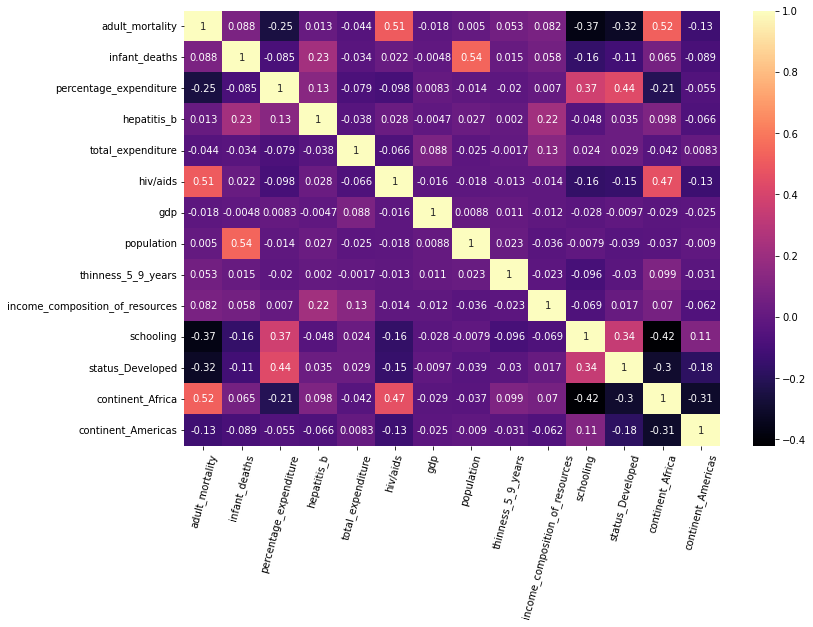

In [ ]:
plt.figure(figsize=(12,8))
g = sns.heatmap(X_train.drop(columns=columns_drop_dt).corr(), cmap='magma', annot=True)
g.set_xticklabels(g.get_xticklabels(), rotation=75)

### Hyperparameter tunning

In [ ]:
cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)
params = {'max_depth':[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
          'random_state':np.arange(15)}
grid_search = GridSearchCV(estimator=DecisionTreeRegressor(), param_grid=params, scoring='r2', cv=cv_sets, verbose= 3, n_jobs=-1)
grid_search.fit(X_train_dt_cleaned, y_train_dt_cleaned)
grid_search = grid_search.best_estimator_

Fitting 10 folds for each of 150 candidates, totalling 1500 fits


In [ ]:
grid_search.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 10,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1,
 'splitter': 'best'}

### Final training model and testing

In [ ]:
Life_Tree = DecisionTreeRegressor(max_depth=10, random_state=0)
X_train_dt_cleanedd = X_train_dt_cleaned.drop(columns = drop_dt)
Life_Tree.fit(X_train_dt_cleanedd, y_train_dt_cleaned)

print("Train score:")
pred = Life_Tree.predict(X_train_dt_cleanedd)
score(y_test=y_train_dt_cleaned, y_pred=pred, score_show=True)
print('<-------------------------------------------------------------------------------------------------->')
print("Test score:")
pred = Life_Tree.predict(X_test.drop(columns=columns_drop_dt))
score(y_test=y_test, y_pred=pred, score_show=True)

Train score:
r2 score: 0.982990554237557
rmse: 1.2420163541763356
mae: 0.7318647000669387
<-------------------------------------------------------------------------------------------------->
Test score:
r2 score: 0.9361899399651377
rmse: 2.4167310268322457
mae: 1.569754137518058


## Random Forest

## Outlier detecting

In [ ]:
X_trainn = X_train.drop(columns=columns_drop)
# Define an Extended Isolation forest model
X_train_rf = X_trainn
X_train_rf['life_expectancy'] = y_train
df_X = h2o.H2OFrame(X_train_rf)
X_train_rf.drop(columns=['life_expectancy'], inplace=True)
eif = H2OExtendedIsolationForestEstimator(model_id = "eif.hex",
                                          ntrees = 100,
                                          sample_size = 256,
                                          extension_level = df_X.dim[1] - 1,
                                          seed = 15
                                          )

# Train Extended Isolation Forest
eif.train(x = df_X.columns, 
          training_frame = df_X)

# Calculate score
eif_result = eif.predict(df_X)

# Number in [0, 1] explicitly defined in Equation (1) from Extended Isolation Forest paper
# or in paragraph '2 Isolation and Isolation Trees' of Isolation Forest paper
anomaly_score = eif_result["anomaly_score"].as_data_frame().values

# Average path length  of the point in Isolation Trees from root to the leaf
mean_length = eif_result["mean_length"].as_data_frame()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%


In [ ]:
r2 = -1
for thres in [0.5, 0.6, 0.7, 0.8, 0.9, 0.98]:
  r2_pred, rmse_pred, mae_pred = evaluate(X_train_rf, y_train, X_test, y_test, estimator='RF', anomaly_score=anomaly_score, columns_drop=columns_drop, threshold=thres, score_show=True)
  print('<------------------------------------------------------------------------------------------------>')
  if r2_pred > r2:
    r2 = r2_pred
    threshold = thres 

Number of anomaly data points with threshold 0.5: 292
r2 score: 0.9523957184371237
rmse: 2.087405141001046
mae: 1.3606161202185771
<------------------------------------------------------------------------------------------------>
Number of anomaly data points with threshold 0.6: 103
r2 score: 0.9560988496393483
rmse: 2.004572145465648
mae: 1.3029141621129339
<------------------------------------------------------------------------------------------------>
Number of anomaly data points with threshold 0.7: 45
r2 score: 0.9562412241643814
rmse: 2.0013190214151617
mae: 1.2787493169398894
<------------------------------------------------------------------------------------------------>
Number of anomaly data points with threshold 0.8: 9
r2 score: 0.9574627834859535
rmse: 1.9731871340161837
mae: 1.2674275956284153
<------------------------------------------------------------------------------------------------>
Number of anomaly data points with threshold 0.9: 0
r2 score: 0.9567638573291141


In [ ]:
X_train_rf_cleaned = X_train_rf.loc[anomaly_score <= threshold]
y_train_rf_cleaned = y_train[anomaly_score <= threshold]

print(X_train_rf_cleaned.shape)
print(y_train_rf_cleaned.shape)

(2187, 24)
(2187, 1)


# https://towardsdatascience.com/how-to-improve-the-accuracy-of-a-regression-model-3517accf8604
# https://towardsdatascience.com/statistics-supporting-linear-models-bfc24fb9781f


## Select features

In [ ]:
compare_loss(X_train, y_train, X_test, y_test, columns=columns_drop, estimator='RF', show_org=True)

Original:
r2 score: 0.959762609599369
rmse: 1.9191045915298297
mae: 1.2141810109289604
Importances of features:
                                 Importances
hiv/aids                            0.199333
adult_mortality                     0.142262
income_composition_of_resources     0.136798
continent_Africa                    0.100311
schooling                           0.082523
thinness_5_9_years                  0.041247
polio                               0.037809
thinness_10_19_years                0.034096
diphtheria                          0.030601
bmi                                 0.028175
under_five_deaths                   0.028143
infant_deaths                       0.018865
gdp                                 0.018162
status_Developed                    0.017216
status_Developing                   0.013344
percentage_expenditure              0.012435
alcohol                             0.009475
population                          0.008463
total_expenditure                

- Dropping features that have importance percentage < 1%

In [ ]:
drop_rf = ['population','continent_Americas','hepatitis_b','continent_Europe','continent_Asia','continent_Oceania']
columns_drop_rf = columns_drop + drop_rf
compare_loss(X_train, y_train, X_test, y_test, columns=columns_drop_rf, estimator='RF')

Dropped:
r2 score: 0.9585947312663227
rmse: 1.946756103496976
mae: 1.2444385245901626
Importances of features:
                                 Importances
hiv/aids                            0.225979
income_composition_of_resources     0.166184
adult_mortality                     0.146020
continent_Africa                    0.125999
schooling                           0.068064
thinness_5_9_years                  0.054169
bmi                                 0.037616
polio                               0.032468
infant_deaths                       0.029326
diphtheria                          0.022990
gdp                                 0.016363
alcohol                             0.013193
status_Developing                   0.013084
status_Developed                    0.011992
percentage_expenditure              0.010926
total_expenditure                   0.009787
year                                0.009700
measles                             0.006138


[Text(0.5, 0, 'year'),
 Text(1.5, 0, 'adult_mortality'),
 Text(2.5, 0, 'infant_deaths'),
 Text(3.5, 0, 'alcohol'),
 Text(4.5, 0, 'percentage_expenditure'),
 Text(5.5, 0, 'measles'),
 Text(6.5, 0, 'bmi'),
 Text(7.5, 0, 'polio'),
 Text(8.5, 0, 'total_expenditure'),
 Text(9.5, 0, 'diphtheria'),
 Text(10.5, 0, 'hiv/aids'),
 Text(11.5, 0, 'gdp'),
 Text(12.5, 0, 'thinness_5_9_years'),
 Text(13.5, 0, 'income_composition_of_resources'),
 Text(14.5, 0, 'schooling'),
 Text(15.5, 0, 'status_Developed'),
 Text(16.5, 0, 'status_Developing'),
 Text(17.5, 0, 'continent_Africa')]

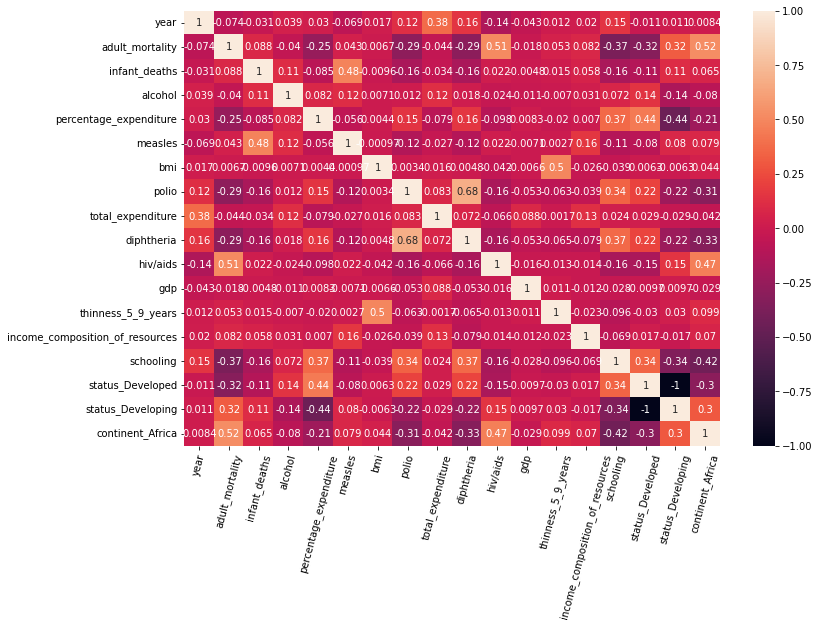

In [ ]:
plt.figure(figsize=(12,8))
g = sns.heatmap(X_train.drop(columns=columns_drop_rf).corr(), annot=True)
g.set_xticklabels(g.get_xticklabels(), rotation=75)

## Hyperparameter tunning

In [34]:
cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)
params_rf = {'n_estimators':np.array(range(50,1000,100)), 'max_features': [0.5,'auto', 'sqrt','log2'], 'min_samples_leaf': [1,2,4]}
grid_search = GridSearchCV(estimator= RandomForestRegressor(random_state=7), param_grid=params_rf, scoring='r2', cv=cv_sets, verbose= 3, n_jobs=-1)
grid_search.fit(X_train_rf_cleaned, y_train_rf_cleaned)
grid_search = grid_search.best_estimator_

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


In [35]:
grid_search.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 0.5,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 450,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 7,
 'verbose': 0,
 'warm_start': False}

## Final training model and testing

In [36]:
Life_RF = RandomForestRegressor(n_estimators=750, random_state = 7, max_features=0.5, min_samples_leaf=1)
X_train_rf_cleanedd = X_train_rf_cleaned.drop(columns = drop_rf)
Life_RF.fit(X_train_rf_cleanedd, y_train_rf_cleaned)

print("Train score:")
pred = Life_RF.predict(X_train_rf_cleanedd)
score(y_test=y_train_rf_cleaned, y_pred=pred, score_show=True)
print('<-------------------------------------------------------------------------------------------------->')
print("Test score:")
X_testtt = X_test.drop(columns=columns_drop_rf)
pred = Life_RF.predict(X_testtt)
score(y_test=y_test, y_pred=pred, score_show=True)

Train score:
r2 score: 0.9950049820210625
rmse: 0.6730553193059887
mae: 0.4147029416247325
<-------------------------------------------------------------------------------------------------->
Test score:
r2 score: 0.9632598281485639
rmse: 1.8338099837537283
mae: 1.133740983606556


# Adaptive Boosting (AdaBoost)

## Outlier detecting

In [17]:
X_trainn = X_train.drop(columns=columns_drop)
# Define an Extended Isolation forest model
X_train_ab = X_trainn
X_train_ab['life_expectancy'] = y_train
df_X = h2o.H2OFrame(X_train_ab)
X_train_ab.drop(columns=['life_expectancy'], inplace=True)
eif = H2OExtendedIsolationForestEstimator(model_id = "eif.hex",
                                          ntrees = 100,
                                          sample_size = 256,
                                          extension_level = df_X.dim[1] - 1,
                                          seed = 15
                                          )

# Train Extended Isolation Forest
eif.train(x = df_X.columns, 
          training_frame = df_X)

# Calculate score
eif_result = eif.predict(df_X)

# Number in [0, 1] explicitly defined in Equation (1) from Extended Isolation Forest paper
# or in paragraph '2 Isolation and Isolation Trees' of Isolation Forest paper
anomaly_score = eif_result["anomaly_score"].as_data_frame().values

# Average path length  of the point in Isolation Trees from root to the leaf
mean_length = eif_result["mean_length"].as_data_frame()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%


In [18]:
r2 = -1
for thres in [0.5, 0.6, 0.7, 0.8, 0.9, 0.98]:
  r2_pred, rmse_pred, mae_pred = evaluate(X_train_ab, y_train, X_test, y_test, estimator='AB', anomaly_score=anomaly_score, columns_drop=columns_drop, threshold=thres, score_show=True)
  print('<------------------------------------------------------------------------------------------------>')
  if r2_pred > r2:
    r2 = r2_pred
    threshold = thres 

Number of anomaly data points with threshold 0.5: 346
r2 score: 0.8898085534752678
rmse: 3.175833190934252
mae: 2.5095601430109875
<------------------------------------------------------------------------------------------------>
Number of anomaly data points with threshold 0.6: 140
r2 score: 0.8896865530312368
rmse: 3.1775907950273936
mae: 2.527648317722771
<------------------------------------------------------------------------------------------------>
Number of anomaly data points with threshold 0.7: 45
r2 score: 0.8889710261614957
rmse: 3.1878795524984667
mae: 2.5589854880380236
<------------------------------------------------------------------------------------------------>
Number of anomaly data points with threshold 0.8: 5
r2 score: 0.8884559135141377
rmse: 3.195265988656258
mae: 2.547805256314455
<------------------------------------------------------------------------------------------------>
Number of anomaly data points with threshold 0.9: 0
r2 score: 0.8918859464744279
rm

In [19]:
X_train_ab_cleaned = X_train_ab.loc[anomaly_score <= threshold]
y_train_ab_cleaned = y_train[anomaly_score <= threshold]

print(X_train_ab_cleaned.shape)
print(y_train_ab_cleaned.shape)

(2196, 22)
(2196, 1)


## Select features

In [20]:
compare_loss(X_train, y_train, X_test, y_test, columns=columns_drop, estimator='AB', show_org=True)

Original:
r2 score: 0.892902022411127
rmse: 3.1309373395352953
mae: 2.4810736758828504
Importances of features:
                                 Importances
hiv/aids                            0.395404
income_composition_of_resources     0.154478
adult_mortality                     0.100277
diphtheria                          0.067066
under_five_deaths                   0.056232
schooling                           0.031173
continent_Africa                    0.030817
thinness_10_19_years                0.022143
polio                               0.022123
alcohol                             0.020206
bmi                                 0.019501
thinness_5_9_years                  0.017778
infant_deaths                       0.016996
status_Developed                    0.014167
total_expenditure                   0.009651
percentage_expenditure              0.005529
status_Developing                   0.005294
population                          0.003249
gdp                              

- Dropping features that have importance percentage < 1%

In [21]:
drop_ab = ['status_Developed','population','continent_Americas','hepatitis_b','status_Developing','continent_Europe','continent_Asia','continent_Oceania']
columns_drop_ab = columns_drop + drop_ab
compare_loss(X_train, y_train, X_test, y_test, columns=columns_drop_ab, estimator='AB')

Dropped:
r2 score: 0.8954007634011045
rmse: 3.094197269778407
mae: 2.3762402550191326
Importances of features:
                                 Importances
hiv/aids                            0.397455
income_composition_of_resources     0.148031
adult_mortality                     0.106472
infant_deaths                       0.086057
diphtheria                          0.079539
thinness_5_9_years                  0.042963
alcohol                             0.037478
schooling                           0.028348
continent_Africa                    0.027740
polio                               0.023868
bmi                                 0.011431
total_expenditure                   0.010618
year                                0.000000
measles                             0.000000


[Text(0.5, 0, 'year'),
 Text(1.5, 0, 'adult_mortality'),
 Text(2.5, 0, 'infant_deaths'),
 Text(3.5, 0, 'alcohol'),
 Text(4.5, 0, 'measles'),
 Text(5.5, 0, 'bmi'),
 Text(6.5, 0, 'polio'),
 Text(7.5, 0, 'total_expenditure'),
 Text(8.5, 0, 'diphtheria'),
 Text(9.5, 0, 'hiv/aids'),
 Text(10.5, 0, 'thinness_5_9_years'),
 Text(11.5, 0, 'income_composition_of_resources'),
 Text(12.5, 0, 'schooling'),
 Text(13.5, 0, 'continent_Africa')]

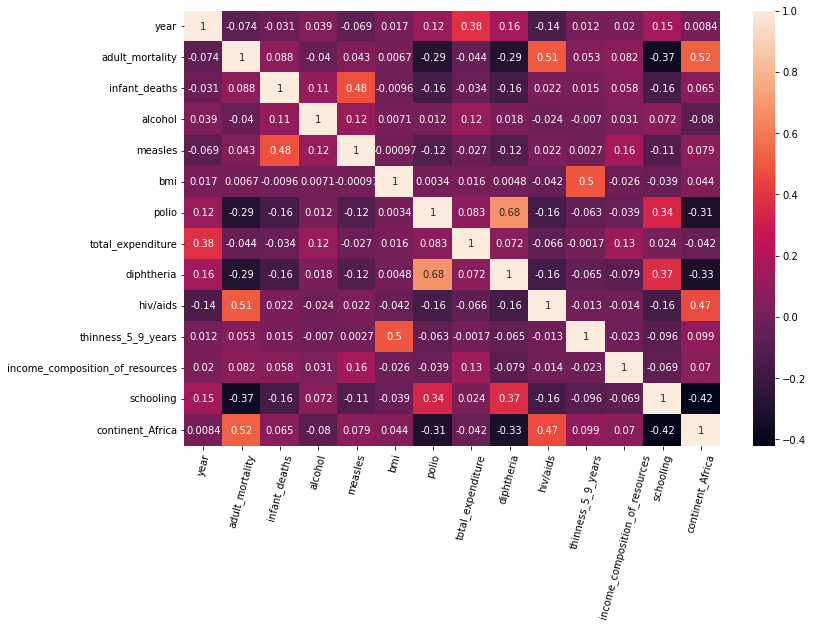

In [22]:
plt.figure(figsize=(12,8))
g = sns.heatmap(X_train.drop(columns=columns_drop_ab).corr(), annot=True)
g.set_xticklabels(g.get_xticklabels(), rotation=75)

## Hyperarameter tunning

In [23]:
cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)
params_ab = {'n_estimators':np.array(range(25,525,25)),"learning_rate": [0.01,0.025,0.05,0.075,0.1,0.25,0.5,0.75,1.0], 'loss': ['linear', 'square','exponential']}
grid_search = GridSearchCV(estimator= AdaBoostRegressor(random_state=15), param_grid=params_ab, scoring='r2', cv=cv_sets, verbose= 3, n_jobs=-1)
grid_search.fit(X_train_ab_cleaned, y_train_ab_cleaned)
grid_search = grid_search.best_estimator_

Fitting 10 folds for each of 540 candidates, totalling 5400 fits


In [24]:
grid_search.get_params()

{'base_estimator': None,
 'learning_rate': 0.5,
 'loss': 'square',
 'n_estimators': 75,
 'random_state': 15}

## Final training model and testing

In [25]:
Life_Ada = AdaBoostRegressor(learning_rate=0.05, n_estimators=275, random_state = 15, loss= 'square')
X_train_ab_cleanedd= X_train_ab_cleaned.drop(columns = drop_ab)
Life_Ada.fit(X_train_ab_cleanedd, y_train_ab_cleaned)

print("Train score:")
pred = Life_Ada.predict(X_train_ab_cleanedd)
score(y_test=y_train_ab_cleaned, y_pred=pred, score_show=True)
print('<-------------------------------------------------------------------------------------------------->')
print("Test score:")
X_testt = X_test.drop(columns=columns_drop_ab)
pred = Life_Ada.predict(X_testt)
score(y_test=y_test, y_pred=pred, score_show=True)

Train score:
r2 score: 0.9089699210522001
rmse: 2.8680596112941594
mae: 2.280244834264894
<-------------------------------------------------------------------------------------------------->
Test score:
r2 score: 0.8906360201808158
rmse: 3.163886491016347
mae: 2.4229867444098323


# Gradient Boosting

## Outlier detecting

In [26]:
X_trainn = X_train.drop(columns=columns_drop)
# Define an Extended Isolation forest model
X_train_gb = X_trainn
X_train_gb['life_expectancy'] = y_train
df_X = h2o.H2OFrame(X_train_gb)
X_train_gb.drop(columns=['life_expectancy'], inplace=True)
eif = H2OExtendedIsolationForestEstimator(model_id = "eif.hex",
                                          ntrees = 100,
                                          sample_size = 256,
                                          extension_level = df_X.dim[1] - 1,
                                          seed = 15
                                          )

# Train Extended Isolation Forest
eif.train(x = df_X.columns, 
          training_frame = df_X)

# Calculate score
eif_result = eif.predict(df_X)

# Number in [0, 1] explicitly defined in Equation (1) from Extended Isolation Forest paper
# or in paragraph '2 Isolation and Isolation Trees' of Isolation Forest paper
anomaly_score = eif_result["anomaly_score"].as_data_frame().values

# Average path length  of the point in Isolation Trees from root to the leaf
mean_length = eif_result["mean_length"].as_data_frame()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
extendedisolationforest Model Build progress: |██████████████████████████████████| (done) 100%
extendedisolationforest prediction progress: |███████████████████████████████████| (done) 100%


In [27]:
r2 = -1
for thres in [0.5, 0.6, 0.7, 0.8, 0.9, 0.98]:
  r2_pred, rmse_pred, mae_pred = evaluate(X_train_gb, y_train, X_test, y_test, estimator='GB', anomaly_score=anomaly_score, columns_drop=columns_drop, threshold=thres, score_show=True)
  print('<------------------------------------------------------------------------------------------------>')
  if r2_pred > r2:
    r2 = r2_pred
    threshold = thres 

Number of anomaly data points with threshold 0.5: 346
r2 score: 0.9049602708601935
rmse: 2.9494180659211864
mae: 2.071233151467811
<------------------------------------------------------------------------------------------------>
Number of anomaly data points with threshold 0.6: 140
r2 score: 0.941077782607818
rmse: 2.3223265226704104
mae: 1.6549002516435207
<------------------------------------------------------------------------------------------------>
Number of anomaly data points with threshold 0.7: 45
r2 score: 0.9407774250371703
rmse: 2.3282380593075764
mae: 1.7096494411820027
<------------------------------------------------------------------------------------------------>
Number of anomaly data points with threshold 0.8: 5
r2 score: 0.9423700594383999
rmse: 2.2967188083773906
mae: 1.6429515305717166
<------------------------------------------------------------------------------------------------>
Number of anomaly data points with threshold 0.9: 0
r2 score: 0.9394973892535302


In [28]:
X_train_gb_cleaned = X_train_gb.loc[anomaly_score <= threshold]
y_train_gb_cleaned = y_train[anomaly_score <= threshold]

print(X_train_gb_cleaned.shape)
print(y_train_gb_cleaned.shape)

(2191, 22)
(2191, 1)


## Select features

In [29]:
compare_loss(X_train, y_train, X_test, y_test, columns=columns_drop, estimator='GB', show_org=True)

Original:
r2 score: 0.9387676385384007
rmse: 2.3674141846683643
mae: 1.6811216391203265
Importances of features:
                                 Importances
schooling                           0.171810
hiv/aids                            0.154048
continent_Africa                    0.152128
polio                               0.133699
adult_mortality                     0.089685
bmi                                 0.075663
income_composition_of_resources     0.064207
diphtheria                          0.025743
thinness_5_9_years                  0.024849
thinness_10_19_years                0.024728
under_five_deaths                   0.021085
gdp                                 0.007045
percentage_expenditure              0.006673
total_expenditure                   0.005946
status_Developed                    0.005580
alcohol                             0.005472
year                                0.005072
hepatitis_b                         0.004591
continent_Americas              

In [30]:
drop_gb = ['year','measles','status_Developing','status_Developed','population','continent_Americas','hepatitis_b','continent_Europe','continent_Asia','continent_Oceania']
columns_drop_gb = columns_drop + drop_gb
compare_loss(X_train, y_train, X_test, y_test, columns=columns_drop_gb, estimator='GB')

Dropped:
r2 score: 0.9404002581797541
rmse: 2.335640139835406
mae: 1.6349449744403162
Importances of features:
                                 Importances
adult_mortality                     0.306605
income_composition_of_resources     0.228888
hiv/aids                            0.203201
infant_deaths                       0.056553
schooling                           0.047552
continent_Africa                    0.039822
thinness_5_9_years                  0.039694
diphtheria                          0.027614
bmi                                 0.020935
polio                               0.016158
total_expenditure                   0.007737
alcohol                             0.005242


[Text(0.5, 0, 'adult_mortality'),
 Text(1.5, 0, 'infant_deaths'),
 Text(2.5, 0, 'alcohol'),
 Text(3.5, 0, 'bmi'),
 Text(4.5, 0, 'polio'),
 Text(5.5, 0, 'total_expenditure'),
 Text(6.5, 0, 'diphtheria'),
 Text(7.5, 0, 'hiv/aids'),
 Text(8.5, 0, 'thinness_5_9_years'),
 Text(9.5, 0, 'income_composition_of_resources'),
 Text(10.5, 0, 'schooling'),
 Text(11.5, 0, 'continent_Africa')]

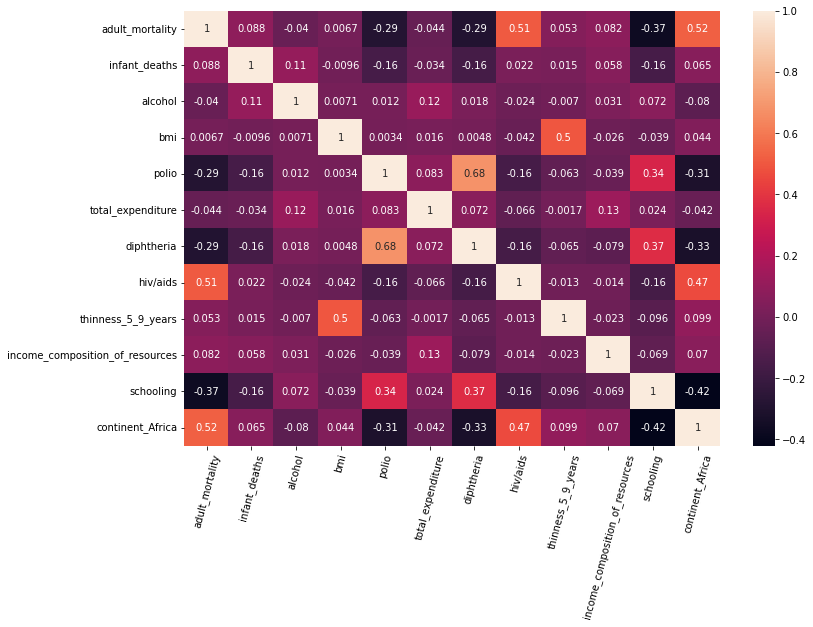

In [31]:
plt.figure(figsize=(12,8))
g = sns.heatmap(X_train.drop(columns=columns_drop_gb).corr(), annot=True)
g.set_xticklabels(g.get_xticklabels(), rotation=75)

## Hyperparameter tunning

In [32]:
cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.2, random_state = 0)
params_gb = {'n_estimators':np.array(range(50,951,100)),"learning_rate": [0.01,0.025,0.05,0.075,0.1,0.25,0.5], 'subsample': [0.5,0.75,1.0], 'max_features': [0.5,'auto','sqrt','log2']}
grid_search = GridSearchCV(estimator= GradientBoostingRegressor(random_state=15), param_grid=params_gb, scoring='r2', cv=cv_sets, verbose= 3, n_jobs=-1)
grid_search.fit(X_train_gb_cleaned, y_train_gb_cleaned)
grid_search = grid_search.best_estimator_

Fitting 10 folds for each of 840 candidates, totalling 8400 fits


In [33]:
grid_search.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': 0.5,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 950,
 'n_iter_no_change': None,
 'random_state': 15,
 'subsample': 0.75,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

## Final training model and testing

In [34]:
Life_GB = GradientBoostingRegressor(learning_rate=0.1, n_estimators=950, random_state = 15, max_features='auto', subsample = 0.75)
X_train_gb_cleanedd = X_train_gb_cleaned.drop(columns = drop_gb)
Life_GB.fit(X_train_gb_cleanedd, y_train_gb_cleaned)

print("Train score:")
pred = Life_GB.predict(X_train_gb_cleanedd)
score(y_test= y_train_gb_cleaned, y_pred=pred, score_show=True)
print('<-------------------------------------------------------------------------------------------------->')
print("Test score:")
X_testtt = X_test.drop(columns=columns_drop_gb)
pred = Life_GB.predict(X_testtt)
score(y_test=y_test, y_pred=pred, score_show=True)

Train score:
r2 score: 0.9952015100669922
rmse: 0.6591183242888199
mae: 0.4775756400366862
<-------------------------------------------------------------------------------------------------->
Test score:
r2 score: 0.9613988508970918
rmse: 1.8796797283038493
mae: 1.2186895950107806
